# 1. Data Collection and Portfolio Construction

### Objective: To create a diversified, equally weighted portfolio comprising five financial instruments across distinct asset classes, and prepare the dataset for volatility modeling.

Data was collected for the period from 2020-05-01 to 2025-05-01.

Instruments chosen:

S&P 500 Index (Equity Index)

Apple Inc. (Stock)

EUR/USD (Currency Pair)

Gold Futures (Commodity)

Ethereum (Cryptocurrency)

All instruments were sourced using Yahoo Finance (yfinance package).

Daily adjusted closing prices were aligned across all instruments.

The portfolio was constructed with equal weights (20%) and daily log returns were calculated.

In [2]:
#Import of Libraries and Packages in order to set the environment
import pandas as pd
import numpy as np
import datetime as dt
import yfinance as yf
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import seaborn as sns
import statsmodels.api as sm
import statsmodels.stats.diagnostic as smd
from statsmodels.tsa.stattools import adfuller, grangercausalitytests, acf, pacf
from statsmodels.tsa.api import VAR
from statsmodels.api import OLS
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.stats.diagnostic import acorr_ljungbox
from IPython.display import Markdown
from arch import arch_model
from scipy import stats
from curl_cffi import requests
from scipy.stats import norm
from scipy.stats import chi2

In [3]:
file_path = "prices.pkl"
prices=pd.read_pickle(file_path)

# 2. Return Computation & Stylized Facts

### Objective: To examine the empirical characteristics of asset returns and verify the presence of volatility modeling stylized facts.

Log returns were calculated for each asset and for the portfolio.

Visual inspection of:

Time series of returns showed periods of high and low volatility clustering.

Squared returns highlighted volatility persistence.

Histogram and Q-Q plot of portfolio returns indicated leptokurtosis (fat tails).

ACF of squared returns suggested the presence of ARCH effects, justifying the use of GARCH-type models.

In [4]:
cols = ['Company_Stock', 'Crypto', 'FX_Pair', 'Commodity', 'Equity_Index']
returns = np.log(prices[cols] / prices[cols].shift(1)).add_suffix('_ret')
prices = pd.concat([prices, returns], axis=1).dropna()
print(prices.filter(like='_ret').head())

Ticker      Company_Stock_ret  Crypto_ret  FX_Pair_ret  Commodity_ret  \
Date                                                                    
2020-05-04           0.014050   -0.028625     0.001292       0.007291   
2020-05-05           0.014898   -0.006746    -0.005062      -0.001466   
2020-05-06           0.010264   -0.013235    -0.006044      -0.011923   
2020-05-07           0.010292    0.039557    -0.003700       0.022080   
2020-05-08           0.023523    0.003302     0.003570      -0.006935   

Ticker      Equity_Index_ret  
Date                          
2020-05-04          0.004241  
2020-05-05          0.009000  
2020-05-06         -0.007004  
2020-05-07          0.011439  
2020-05-08          0.016731  


In [5]:
def portfolio_return(df):
    assets = ['Company_Stock_ret', 'Crypto_ret', 'FX_Pair_ret', 'Commodity_ret', 'Equity_Index_ret']
    weight = 1 / len(assets)
    df['portfolio'] = df[assets].mul(weight).sum(axis=1)
    return df
df = portfolio_return(prices)
df.columns

Index(['Company_Stock', 'Crypto', 'FX_Pair', 'Commodity', 'Equity_Index',
       'Company_Stock_ret', 'Crypto_ret', 'FX_Pair_ret', 'Commodity_ret',
       'Equity_Index_ret', 'portfolio'],
      dtype='object', name='Ticker')

In [6]:
train = prices.iloc[:-261]  
test  = prices.iloc[-261:] 

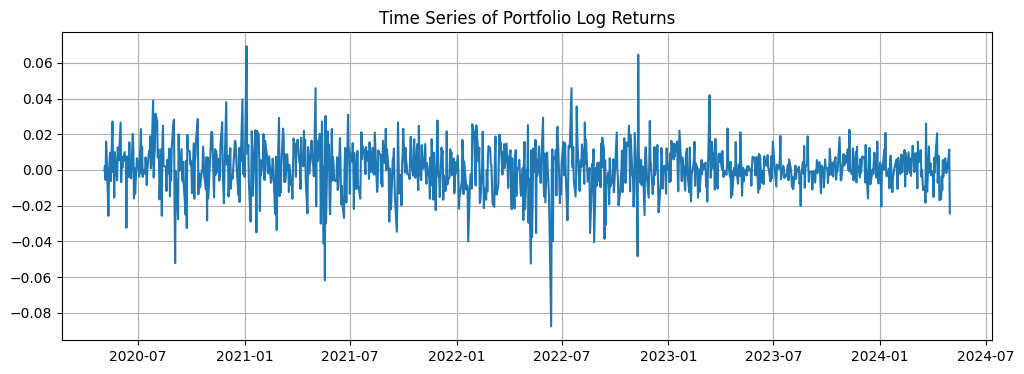

In [7]:
# Plot time series of returns
plt.figure(figsize=(12, 4))
plt.plot(train['portfolio'])
plt.title('Time Series of Portfolio Log Returns')
plt.grid(True)
plt.show()

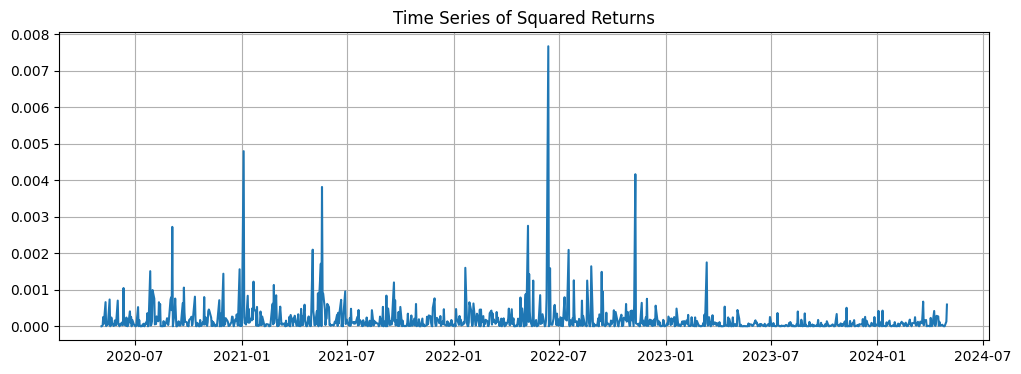

In [8]:
# Plot squared returns
plt.figure(figsize=(12, 4))
plt.plot(train['portfolio'] ** 2)
plt.title('Time Series of Squared Returns')
plt.grid(True)
plt.show()

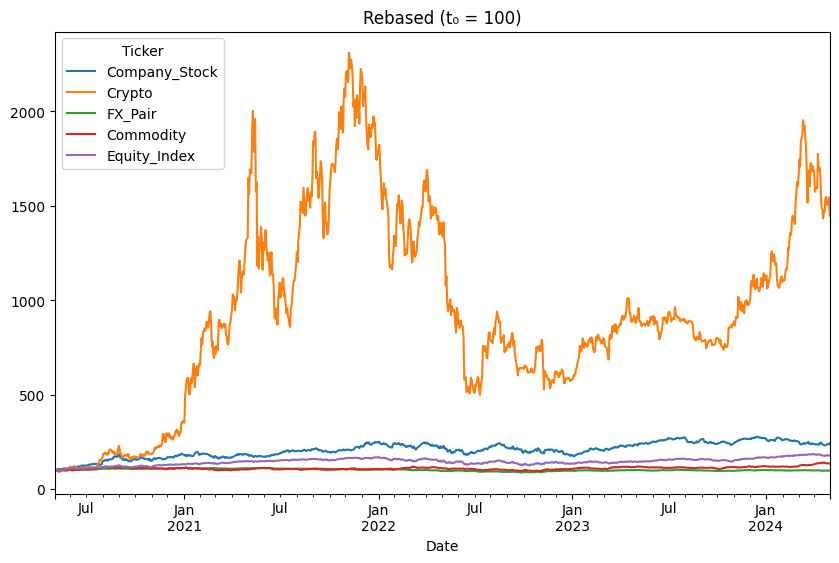

In [9]:
cols = ['Company_Stock', 'Crypto', 'FX_Pair', 'Commodity', 'Equity_Index']

train[cols].div(train[cols].iloc[0]).mul(100).plot(figsize=(10, 6), title="Rebased (t₀ = 100)")
plt.show()


In [10]:
def adf_test0(series, max_lag=3):
    result = adfuller(series.dropna(), maxlag=max_lag, autolag=None)
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    print(f"Critical Values: {result[4]}")


In [11]:
adf_test0(train['Company_Stock_ret'])
adf_test0(train['Crypto_ret'])
adf_test0(train['FX_Pair_ret'])
adf_test0(train['Commodity_ret'])
adf_test0(train['Equity_Index_ret'])

ADF Statistic: -16.36576797986547
p-value: 2.8417613594191543e-29
Critical Values: {'1%': np.float64(-3.4366655541494944), '5%': np.float64(-2.8643284548748533), '10%': np.float64(-2.5682546880209087)}
ADF Statistic: -15.842969744781632
p-value: 9.644316672905744e-29
Critical Values: {'1%': np.float64(-3.4366655541494944), '5%': np.float64(-2.8643284548748533), '10%': np.float64(-2.5682546880209087)}
ADF Statistic: -16.26980760682723
p-value: 3.497261610637794e-29
Critical Values: {'1%': np.float64(-3.4366655541494944), '5%': np.float64(-2.8643284548748533), '10%': np.float64(-2.5682546880209087)}
ADF Statistic: -15.965084837314926
p-value: 7.106966336420415e-29
Critical Values: {'1%': np.float64(-3.4366655541494944), '5%': np.float64(-2.8643284548748533), '10%': np.float64(-2.5682546880209087)}
ADF Statistic: -17.08971776154879
p-value: 7.605652155453357e-30
Critical Values: {'1%': np.float64(-3.4366655541494944), '5%': np.float64(-2.8643284548748533), '10%': np.float64(-2.56825468802

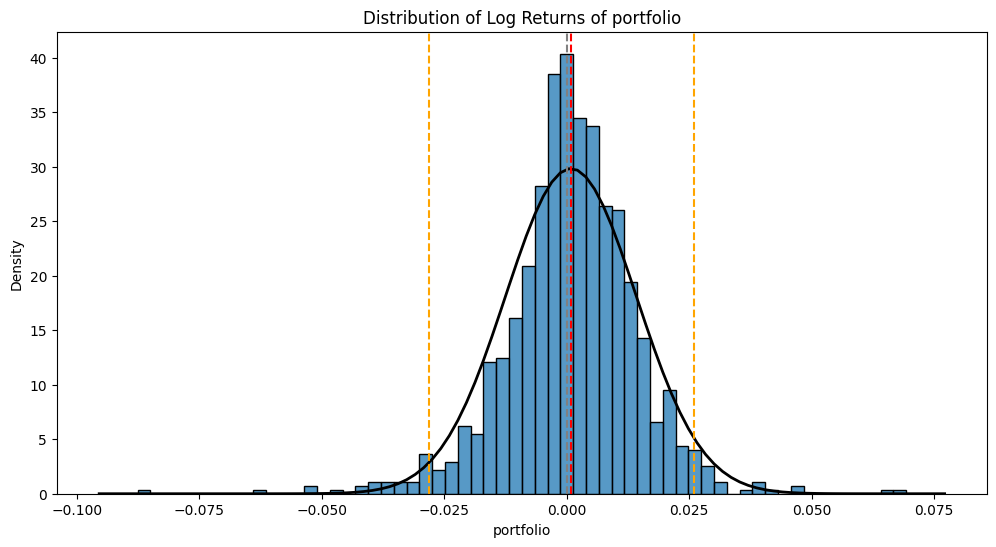

In [12]:
# Histogram of log returns
plt.figure(figsize=(12, 6))
sns.histplot(train['portfolio'].dropna(), stat="density", bins = 60)
# add normal distribution curve
mu, std = train['portfolio'].mean(), train['portfolio'].std()
xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = stats.norm.pdf(x, mu, std)
plt.plot(x, p, 'k', linewidth=2)
plt.axvline(x=0, linestyle='--', color='gray')
plt.axvline(x=train['portfolio'].mean(), linestyle='--', color='red')
plt.axvline(x=train['portfolio'].quantile(0.025), linestyle='--', color='orange')
plt.axvline(x=train['portfolio'].quantile(0.975), linestyle='--', color='orange')
plt.title('Distribution of Log Returns of portfolio')
plt.show()

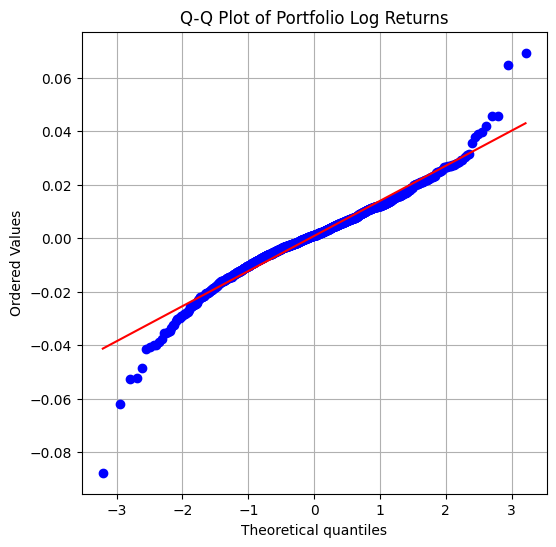

In [13]:
# Q-Q plot
plt.figure(figsize=(6, 6))
stats.probplot(train['portfolio'], dist="norm", plot=plt)
plt.title('Q-Q Plot of Portfolio Log Returns')
plt.grid(True)
plt.show()

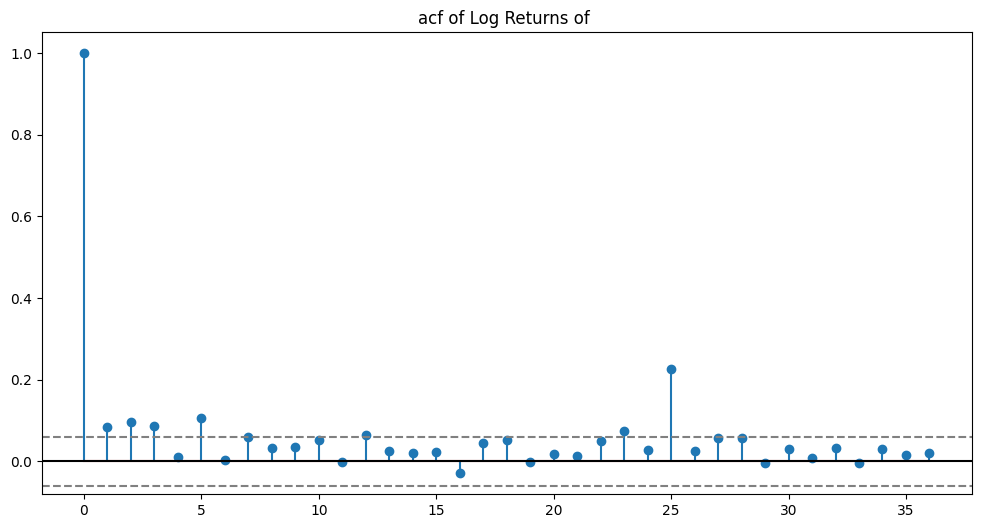

In [14]:
# Autocorrelation function for squared log returns.
version = acf
acf_values = version((train['portfolio']**2).dropna(), nlags=36)
plt.figure(figsize=(12, 6))
plt.stem(range(len(acf_values)), acf_values)
plt.axhline(y=0, linestyle='-', color='black')
plt.axhline(y=-1.96/np.sqrt(len(train['portfolio'])), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(train['portfolio'])), linestyle='--', color='gray')
plt.title(f'{version.__name__} of Log Returns of ')
plt.show()

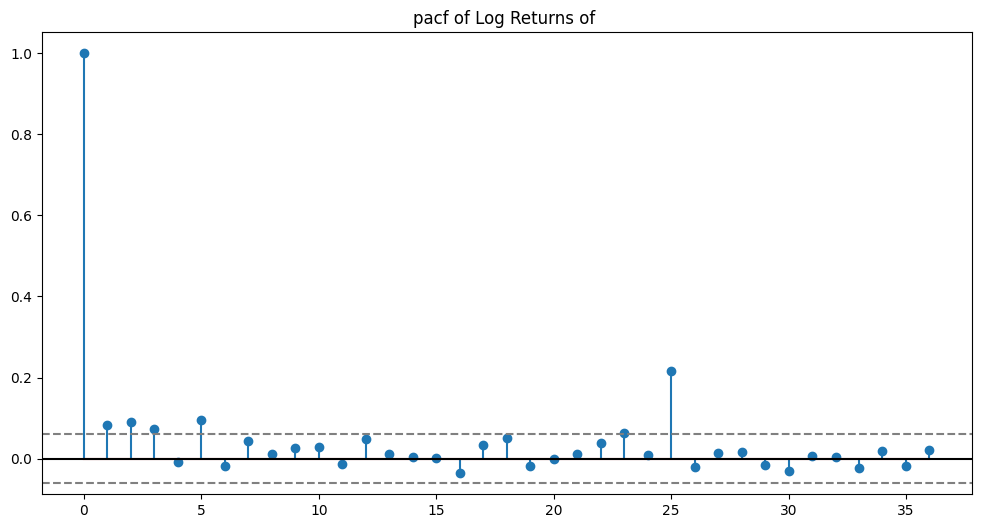

In [15]:
# Autocorrelation function for squared log returns.
version = pacf
acf_values = version((train['portfolio']**2).dropna(), nlags=36)
plt.figure(figsize=(12, 6))
plt.stem(range(len(acf_values)), acf_values)
plt.axhline(y=0, linestyle='-', color='black')
plt.axhline(y=-1.96/np.sqrt(len(train['portfolio'])), linestyle='--', color='gray')
plt.axhline(y=1.96/np.sqrt(len(train['portfolio'])), linestyle='--', color='gray')
plt.title(f'{version.__name__} of Log Returns of ')
plt.show()

In [16]:
print("Basic statistics:")
print(train['portfolio'].describe())
print("\nSkewness:", stats.skew(train['portfolio'].dropna()))
print("Kurtosis:", stats.kurtosis(train['portfolio'].dropna()))
print("Jarque-Bera: stat=%.2f, p=%.2e" % stats.jarque_bera(train['portfolio'].dropna()))


Basic statistics:
count    1042.000000
mean        0.000841
std         0.013372
min        -0.087611
25%        -0.005960
50%         0.001061
75%         0.008610
max         0.069283
Name: portfolio, dtype: float64

Skewness: -0.4105285008213672
Kurtosis: 3.974926008073103
Jarque-Bera: stat=715.25, p=4.84e-156


In [17]:
# Kolmogorov–Smirnov (KS) test
params = stats.t.fit(train['portfolio'].dropna())
print("KS stat, p-value:", *stats.kstest(train['portfolio'].dropna(), "t", args=params))


KS stat, p-value: 0.013566450437966338 0.9894826382326687


## Conclusion
Hence we have valid reasons to say that the returns exhibit typical features of financial data — time-varying volatility, excess kurtosis, ARCH effects and, as the Jarque-Bera rejection confirms, a non-normal (skewed/heavy-tailed) distribution.

# 3. Model Specification & Estimation

### Objective: Fit and estimate two volatility models — GARCH(1,1) and EGARCH(1,1) — to capture conditional heteroskedasticity.

In-sample period: 2020-05-01 to 2024-04-30

Out-of-sample period: 2024-05-01 to 2025-05-01

Both models were fitted using the arch package.

Diagnostic tests:

Ljung-Box test showed no significant autocorrelation in residuals.

ARCH LM test confirmed removal of ARCH effects.

EGARCH explicitly models asymmetries in returns and accounts for the leverage effect (negative shocks increasing volatility more than positive ones).



In [48]:
def fit_garch(train_returns_pct, p =1, q=1, dist='ged'):
    model = arch_model(train_returns_pct, vol='GARCH', p=p, q=q, dist=dist)
    res   = model.fit(disp='off')
    alpha = res.params["alpha[1]"]
    beta  = res.params["beta[1]"]
    # --- annualized conditional σ (pct units) ---
    ann_sigma_pct = res.conditional_volatility * np.sqrt(252)
    res.ann_cond_std = ann_sigma_pct / 100          # store as decimals for convenience
    std_resid = res.resid / res.conditional_volatility
    return res, alpha, beta, std_resid

# --- 1. fit EGARCH once to get in-sample annualized σ̂ ----------------------
def fit_egarch(train_returns_pct, p=1, o=1, q=1, dist = 'ged', start_params=None):

    model = arch_model(train_returns_pct, vol='EGARCH',
                       p=p, o=o, q=q, dist=dist)
    res   = model.fit(disp='off', starting_values=start_params)
    alpha = res.params["alpha[1]"]
    beta  = res.params["beta[1]"]
    ann_sigma_pct = res.conditional_volatility * np.sqrt(252)
    res.ann_cond_std = ann_sigma_pct / 100      # store as decimals
    std_resid = res.resid / res.conditional_volatility
    
    return res, alpha, beta, std_resid

In [49]:
def rolling_garch_var(train_test, split_idx, alpha=0.05, window=None,
                      p=1, q=1, o=1, vol='GARCH', dist= 'ged', start_params=None):
    
    start_params = start_params
    test_index  = train_test.loc[split_idx:].index[1:]
    sig2_list, var_list = [], []

    for t in test_index:
        train_slice = train_test.loc[:t - pd.Timedelta(days=1)]
        if window:
            train_slice = train_slice.tail(window)  

        if vol == 'GARCH':
            res, arch_alpha, beta, _ = fit_garch(train_slice*100, p=p, q=q, dist = dist)
        else:
            res, arch_alpha, beta, _ = fit_egarch(train_slice*100, p=p, o=o, q=q, dist=dist,start_params=start_params)
        if getattr(res, "converged", getattr(res, "success", True)):
            start_params = res.params.values
        
        sigma  = np.sqrt(res.forecast(horizon=1).variance.values[-1, 0]) / 100
        VaR_t = -norm.ppf(alpha) * sigma
        sig2_list.append(sigma**2)             # store decimal variance directly
        var_list.append(VaR_t)

    return (pd.Series(sig2_list, index=test_index, name=f'{vol}_σ2'),
            pd.Series(var_list,  index=test_index, name=f'{vol}_VaR'))
    
#%%
def rolling_garch_var_1(train_test, split_idx, alpha=0.05, window=None,
                      p=1, q=1, o=1, vol='GARCH',dist = 'ged', start_params=None):
    
    start_params = start_params
    test_index  = train_test.loc[split_idx:].index[1:]
    sig2_list, var_list = [], []

    for t in test_index:
        train_slice = train_test.loc[:t - pd.Timedelta(days=1)]
        if window:
            train_slice = train_slice.tail(window)  

        if vol == 'GARCH':
            res, arch_alpha, beta, _ = fit_garch(train_slice*100, p=p, q=q, dist = dist)
        else:
            res, arch_alpha, beta, _ = fit_egarch(train_slice*100, p=p, o=o, q=q, dist= dist, start_params=start_params)
        if getattr(res, "converged", getattr(res, "success", True)):
            start_params = res.params.values
        
        sigma  = np.sqrt(res.forecast(horizon=1).variance.values[-1, 0]) / 100
        VaR_t = -norm.ppf(alpha) * sigma
        sig2_list.append(sigma**2)             # store decimal variance directly
        var_list.append(VaR_t)

    return (pd.Series(sig2_list, index=test_index, name=f'{vol}_σ2'),
            pd.Series(var_list,  index=test_index, name=f'{vol}_VaR'))


In [50]:
def violation_ratio(returns, var):
    breaches = returns < -var
    return breaches.sum() / len(breaches)

In [108]:
# MAIN - BASE GARCH VARIANTS
def main(train, test, alpha=0.05, window= None, p=1, o=1, q=1, dist='normal'):
    train = train.copy()
    def _init_params(dist):
        mapping = {
            'normal': [0.0, 0.0, 0.05, 0.0, 0.90],
            't':      [0.0, 0.0, 0.05, 0.0, 0.90, 10.0],
            'skewt':  [0.0, 0.0, 0.05, 0.0, 0.90, 10.0, 0.0],
            'ged':    [0.0, 0.0, 0.05, 0.0, 0.90, 1.5],
        }
        try:
            return np.array(mapping[dist])
        except KeyError:
            raise ValueError(f"Unknown dist: {dist}")

    prev_params = _init_params(dist)
    # --- in-sample fits ----------------------------------------------------
    res_g ,alpha_gar, beta_gar, std_resid_gar= fit_garch(train['portfolio'] * 100, p=p, q=q, dist=dist)
    res_e , alpha_egar, beta_egar, std_resid_egar= fit_egarch(train['portfolio']* 100, p=p, o=o, q=q, dist=dist, start_params=prev_params)
    train['ann_sigma_garch']  = res_g.ann_cond_std
    train['ann_sigma_egarch'] = res_e.ann_cond_std

    print('alpha+beta for GARCH:', res_g.params.filter(like='alpha').sum() + res_g.params.filter(like='beta').sum())

    print('beta sum for EGARCH:', res_e.params.filter(like='beta').sum())
    
    
    # --- rolling out-of-sample -------------------------------------------
    full_ret  = pd.concat([train['portfolio'], test['portfolio']])
    split_idx = train.index[-1]       # the cut-off between in-sample and out-of-sample

    _, VaR_g = rolling_garch_var(full_ret, split_idx, alpha=alpha,
                                          window=window, vol='GARCH', p=p, q=q, dist=dist)
    _, VaR_e = rolling_garch_var(full_ret, split_idx, alpha=alpha,
                                          window=window, vol='EGARCH', p=p, o=o, q=q, dist=dist, start_params=prev_params)
     # --- out  of sample breach rates ------------------------------------------------------
    vr_g = violation_ratio(test['portfolio'], VaR_g.loc[test.index])
    vr_e = violation_ratio(test['portfolio'], VaR_e.loc[test.index])
    print(f"GARCH({dist}) breach rate OoS: {vr_g*100:.2f}%")
    print(f"EGARCH({dist}) breach rate OoS: {vr_e*100:.2f}%")

    
    VaR_g_is = -norm.ppf(alpha) * res_g.conditional_volatility /100
    VaR_e_is = -norm.ppf(alpha) * res_e.conditional_volatility /100
     # --- in sample breach rates ------------------------------------------------------
    vr_g = violation_ratio(train['portfolio'], VaR_g_is)
    vr_e = violation_ratio(train['portfolio'], VaR_e_is)
    print(f"GARCH({dist}) breach rate IS: {vr_g*100:.2f}%")
    print(f"EGARCH({dist}) breach rate IS: {vr_e*100:.2f}%")

    
    # --- plot - In sample -------------------------------------------------------------
    ax = VaR_g_is.plot(label='GARCH VaR', figsize=(10,4))
    VaR_e_is.plot(ax=ax, label='EGARCH VaR')
    train['portfolio'].plot(ax=ax, alpha=0.4, label='Returns')
    ax.set_title(f"IS VaR: GARCH({dist}) vs. EGARCH({dist})"); ax.legend()

    plt.show()
    # --- plot - Out of Sample -------------------------------------------
    
    ax = VaR_g.plot(label='GARCH VaR', figsize=(10,4))
    VaR_e.plot(ax=ax, label='EGARCH VaR')
    test['portfolio'].plot(ax=ax, alpha=0.4, label='Returns')
    ax.set_title(f"OOS VaR: GARCH({dist}) vs. EGARCH({dist})"); ax.legend()
    plt.show()
    return res_g, res_e, VaR_g, VaR_e, vr_g, vr_e, std_resid_gar, std_resid_egar


In [109]:
# MAIN_1 - GARCH VARIANTS WITH HIGHER ORDER TERMS.(copy of main)
def main_1(train, test, alpha=0.05, window= None, p=5, o=1, q=5, dist='skewt'):
    
    train = train.copy()
    def _get_prev_params(p, o, q, dist):
        # map (p,o,q,dist) → default start array
        mapping = {
            (5, 1, 5, 't'):   np.array([0.0, 0.0, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.18, 0.18, 0.18, 0.18, 0.18, 6.0]),
            (5, 1, 3, 't'):   np.array([0.0, 0.0, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.03, 0.03, 0.03, 8.0]),
            (3, 1, 5, 't'):   np.array([0.0, 0.0, 0.017, 0.017, 0.017, 0.0, 0.18, 0.18, 0.18, 0.18, 0.18, 8.0]),
            (1,2,1,'ged'):   np.array([0.0,0.0,0.05,0.0,0.0,0.9,6.0]),
            (5,1,5,'ged'):   np.array([0.0,0.0,0.01,0.01,0.01,0.01,0.01,0.0,0.18,0.18,0.18,0.18,0.18,6.0]),
            (5,1,3,'ged'):   np.array([0.0,0.0,0.01,0.01,0.01,0.01,0.01,0.0,0.03,0.03,0.03,8.0]),
            (5,1,3,'skewt'):np.array([0.0,0.0,0.01,0.01,0.01,0.01,0.01,0.0,0.03,0.03,0.03,10.0,0.0]),
            (3,1,5,'ged'):   np.array([0.0,0.0,0.017,0.017,0.017,0.0,0.18,0.18,0.18,0.18,0.18,8.0]),
            (5,2,3,'ged'):   np.array([0.0,0.0,0.01,0.01,0.01,0.01,0.01,0.0,0.0,0.03,0.03,0.03,8.0]),
            (5, 1, 3, 'normal'): np.array([0.0, 0.0, 0.01, 0.01, 0.01, 0.01, 0.01, 0.0, 0.03, 0.03, 0.03]),

        }
        try:
            return mapping[(p, o, q, dist)]
        except KeyError:
            raise ValueError(f"No prev_params defined for p={p}, o={o}, q={q}, dist='{dist}'")

    # if the user hasn't supplied prev_params explicitly, pick the default
    prev_params = _get_prev_params(p, o, q, dist)

    # --- in-sample fits ----------------------------------------------------
    res_g ,alpha_gar, beta_gar, std_resid_gar= fit_garch(train['portfolio'] * 100, p=p, q=q, dist=dist)
    res_e , alpha_egar, beta_egar, std_resid_egar= fit_egarch(train['portfolio']* 100, p=p, o=o, q=q,dist=dist, start_params=prev_params)
    train['ann_sigma_garch']  = res_g.ann_cond_std
    train['ann_sigma_egarch'] = res_e.ann_cond_std


    print('alpha+beta for GARCH:', res_g.params.filter(like='alpha').sum() + res_g.params.filter(like='beta').sum())

    print('beta sum for EGARCH:', res_e.params.filter(like='beta').sum())    
    # --- rolling out-of-sample -------------------------------------------
    full_ret  = pd.concat([train['portfolio'], test['portfolio']])
    split_idx = train.index[-1]       # the cut-off between in-sample and out-of-sample

    _, VaR_g = rolling_garch_var_1(full_ret, split_idx, alpha=alpha,
                                          window=window, vol='GARCH', p=p, q=q, dist=dist)
    _, VaR_e = rolling_garch_var_1(full_ret, split_idx, alpha=alpha,
                                          window=window, vol='EGARCH', p=p, o=o, q=q, dist=dist, start_params=prev_params)
     # --- out  of sample breach rates ------------------------------------------------------
    vr_g = violation_ratio(test['portfolio'], VaR_g.loc[test.index])
    vr_e = violation_ratio(test['portfolio'], VaR_e.loc[test.index])
    print(f"GARCH({dist}) breach rate OoS: {vr_g*100:.2f}%")
    print(f"EGARCH({dist}) breach rate OoS: {vr_e*100:.2f}%")
    
    VaR_g_is = -norm.ppf(alpha) * res_g.conditional_volatility /100
    VaR_e_is = -norm.ppf(alpha) * res_e.conditional_volatility /100
     # --- in sample breach rates ------------------------------------------------------
    vr_g = violation_ratio(train['portfolio'], VaR_g_is)
    vr_e = violation_ratio(train['portfolio'], VaR_e_is)
    print(f"GARCH({dist}) breach rate IS: {vr_g*100:.2f}%")
    print(f"EGARCH({dist}) breach rate IS: {vr_e*100:.2f}%")
        # --- plot - In sample -------------------------------------------------------------
    ax = VaR_g_is.plot(label='GARCH VaR', figsize=(10,4))
    VaR_e_is.plot(ax=ax, label='EGARCH VaR')
    train['portfolio'].plot(ax=ax, alpha=0.4, label='Returns')
    ax.set_title(f"IS VaR: GARCH({dist}) vs. EGARCH({dist})"); ax.legend()

    plt.show()
    # --- plot - Out of Sample -------------------------------------------
    
    ax = VaR_g.plot(label='GARCH VaR', figsize=(10,4))
    VaR_e.plot(ax=ax, label='EGARCH VaR')
    test['portfolio'].plot(ax=ax, alpha=0.4, label='Returns')
    ax.set_title(f"OOS VaR: GARCH({dist}) vs. EGARCH({dist})"); ax.legend()
    plt.show()


    return res_g, res_e, VaR_g, VaR_e, vr_g, vr_e, std_resid_gar, std_resid_egar


# 4. Model Outputs

### We fit all models with 3 distribution specifications, namely t-dist, skew-t, normal and ged.

alpha+beta for GARCH: 0.9964890331009527
beta sum for EGARCH: 0.9948409442484768
GARCH(t) breach rate OoS: 4.98%
EGARCH(t) breach rate OoS: 6.51%
GARCH(t) breach rate IS: 4.22%
EGARCH(t) breach rate IS: 4.22%


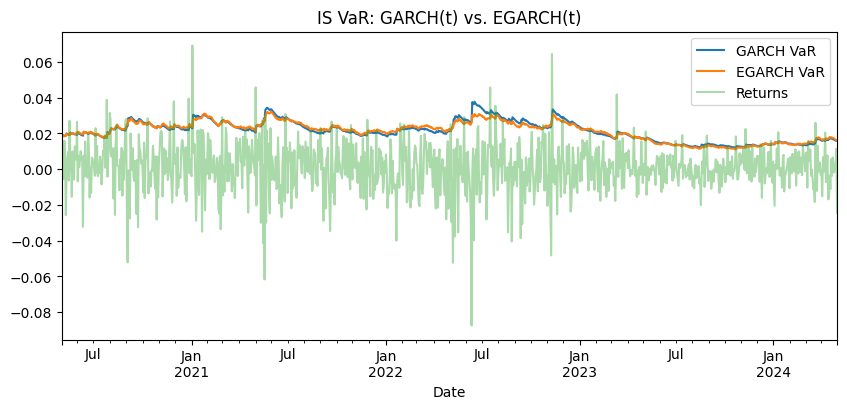

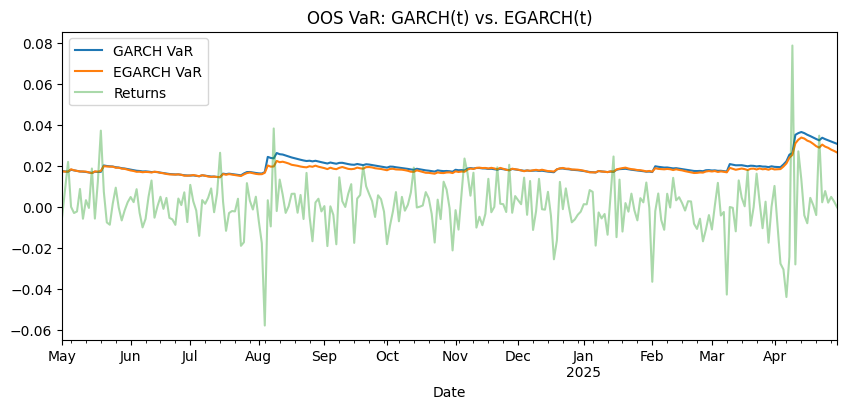

alpha+beta for GARCH: 0.9911757546606625
beta sum for EGARCH: 0.9859339280624266
GARCH(t) breach rate OoS: 5.75%
EGARCH(t) breach rate OoS: 5.75%
GARCH(t) breach rate IS: 4.41%
EGARCH(t) breach rate IS: 4.22%


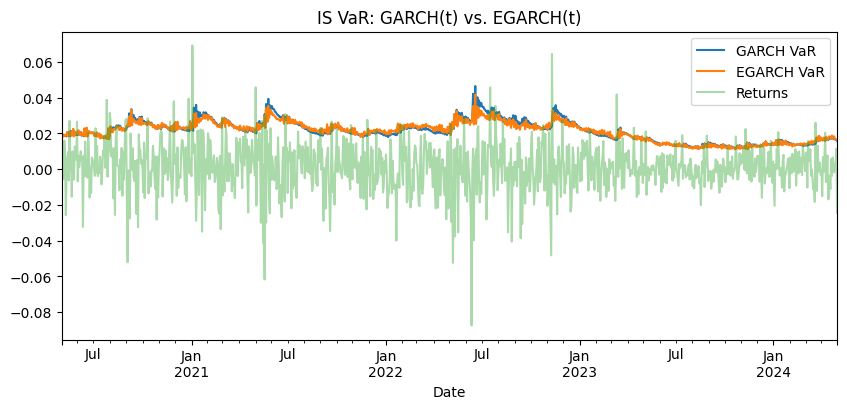

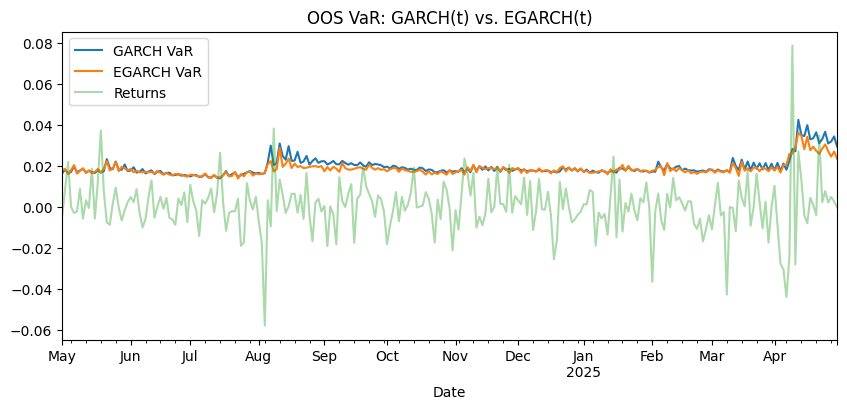

In [115]:
# Under dist = 't'
if __name__ == "__main__":

    res_g_0_t, res_e_0_t, VaR_g_0_t, VaR_e_0_t, vr_g_0_t, vr_e_0_t, std_resid_gar_0_t, std_resid_egar_0_t  = main(train, test, alpha=0.05, window= None, p=1, o=1, q=1, dist='t')

if __name__ == "__main__":
    res_g_1_t, res_e_1_t, VaR_g_1_t, VaR_e_1_t, vr_g_1_t, vr_e_1_t, std_resid_gar_1_t, std_resid_egar_1_t  = main_1(train, test, alpha=0.05, window= None, p=5, o=1, q=3, dist = 't')


alpha+beta for GARCH: 0.9964653116029607
beta sum for EGARCH: 0.9946507746082294
GARCH(skewt) breach rate OoS: 4.98%
EGARCH(skewt) breach rate OoS: 6.51%
GARCH(skewt) breach rate IS: 4.13%
EGARCH(skewt) breach rate IS: 4.22%


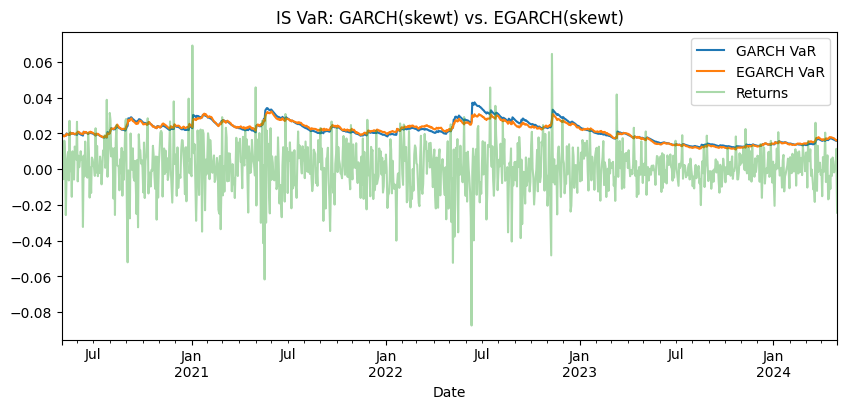

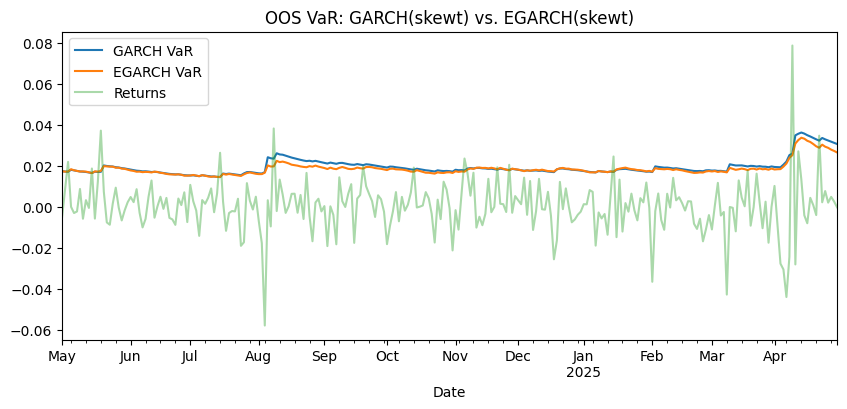

alpha+beta for GARCH: 0.9914158404870888
beta sum for EGARCH: 0.9851321907848063
GARCH(skewt) breach rate OoS: 5.36%
EGARCH(skewt) breach rate OoS: 5.75%
GARCH(skewt) breach rate IS: 4.32%
EGARCH(skewt) breach rate IS: 4.22%


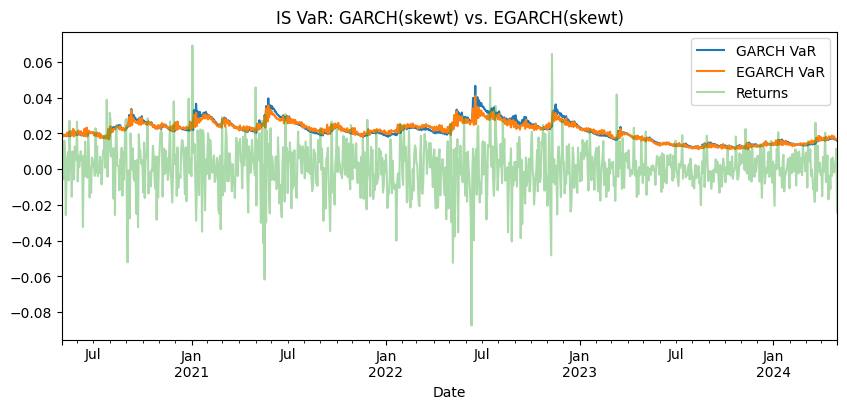

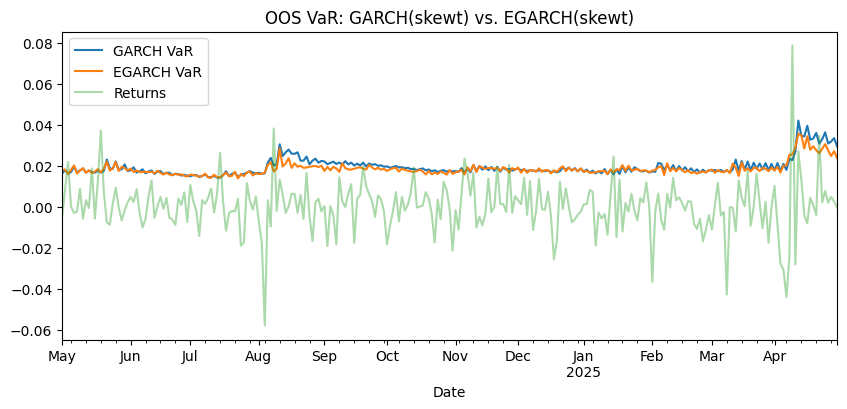

In [116]:
# Under dist = 'skewt'
if __name__ == "__main__":

    res_g_0_skt, res_e_0_skt, VaR_g_0_skt, VaR_e_0_skt, vr_g_0_skt, vr_e_0_skt, std_resid_gar_0_skt, std_resid_egar_0_skt  = main(train, test, alpha=0.05, window= None, p=1, o=1, q=1, dist='skewt')


if __name__ == "__main__":
    res_g_1_skt, res_e_1_skt, VaR_g_1_skt, VaR_e_1_skt, vr_g_1_skt, vr_e_1_skt, std_resid_gar_1_skt, std_resid_egar_1_skt  = main_1(train, test, alpha=0.05, window= None, p=5, o=1, q=3, dist = 'skewt')


alpha+beta for GARCH: 0.9977272814552333
beta sum for EGARCH: 0.9958073970805952
GARCH(normal) breach rate OoS: 4.98%
EGARCH(normal) breach rate OoS: 5.75%
GARCH(normal) breach rate IS: 4.22%
EGARCH(normal) breach rate IS: 4.03%


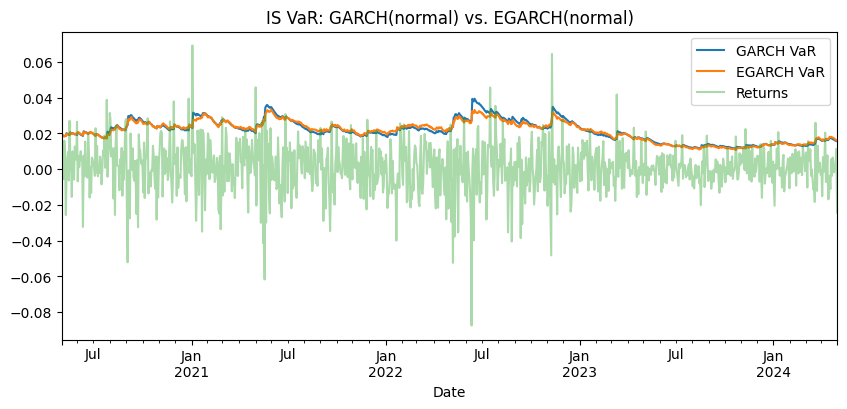

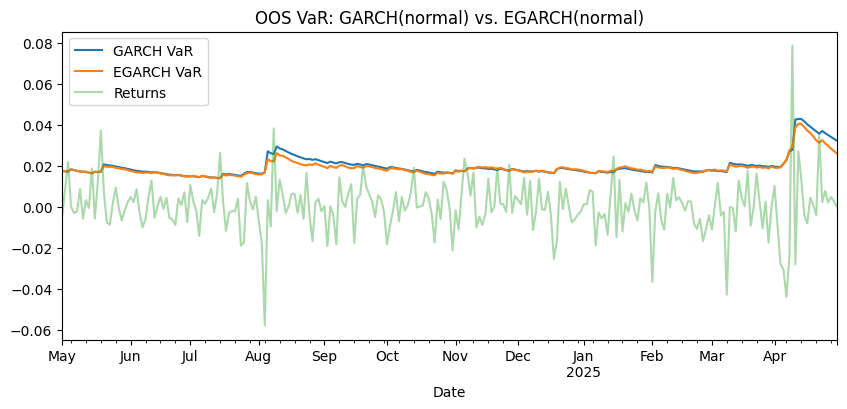

alpha+beta for GARCH: 0.9930262369689039
beta sum for EGARCH: 0.9884250273006552
GARCH(normal) breach rate OoS: 5.36%
EGARCH(normal) breach rate OoS: 6.51%
GARCH(normal) breach rate IS: 4.32%
EGARCH(normal) breach rate IS: 4.51%


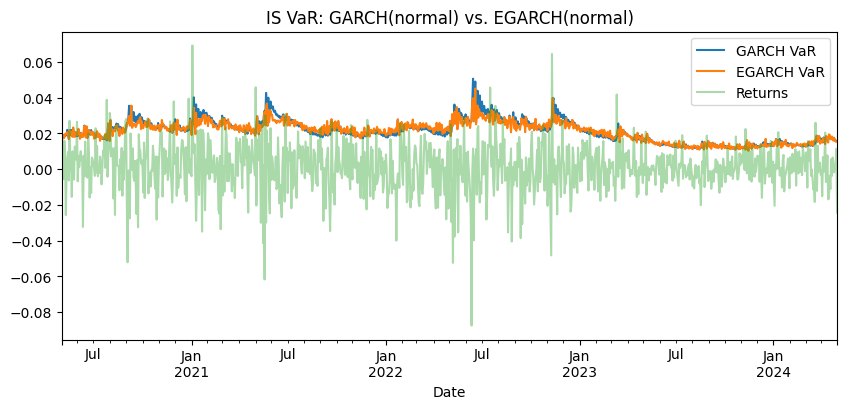

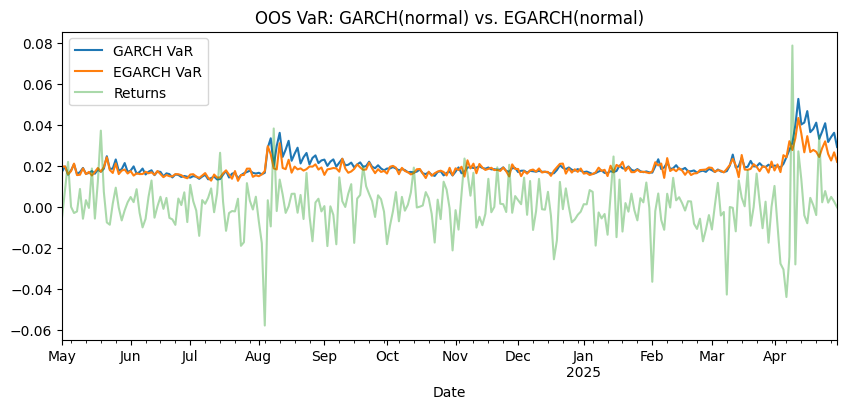

In [121]:
# Under dist = 'normal'
if __name__ == "__main__":

    res_g_0_norm, res_e_0_norm, VaR_g_0_norm, VaR_e_0_norm, vr_g_0_norm, vr_e_0_norm, std_resid_gar_0_norm, std_resid_egar_0_norm  = main(train, test, alpha=0.05, window= None, p=1, o=1, q=1, dist='normal')


if __name__ == "__main__":
    res_g_1_norm, res_e_1_norm, VaR_g_1_norm, VaR_e_1_norm, vr_g_1_norm, vr_e_1_norm, std_resid_gar_1_norm, std_resid_egar_1_norm  = main_1(train, test, alpha=0.05, window= None, p=5, o=1, q=3, dist = 'normal')


alpha+beta for GARCH: 0.9968677047682608
beta sum for EGARCH: 0.9955418328160262
GARCH(ged) breach rate OoS: 4.98%
EGARCH(ged) breach rate OoS: 6.13%
GARCH(ged) breach rate IS: 4.22%
EGARCH(ged) breach rate IS: 4.32%


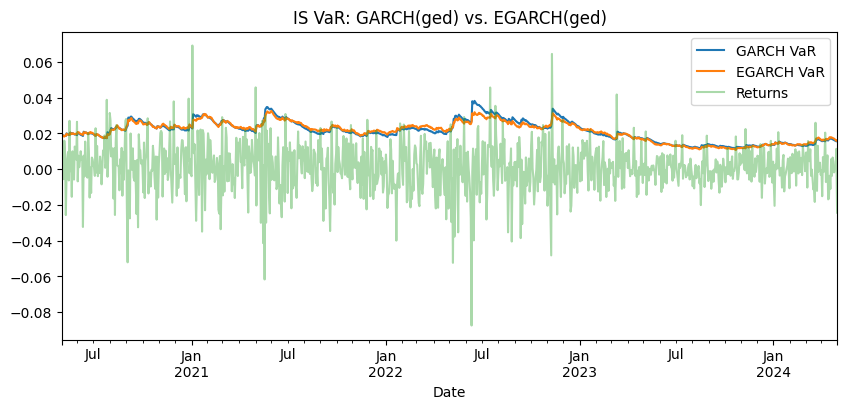

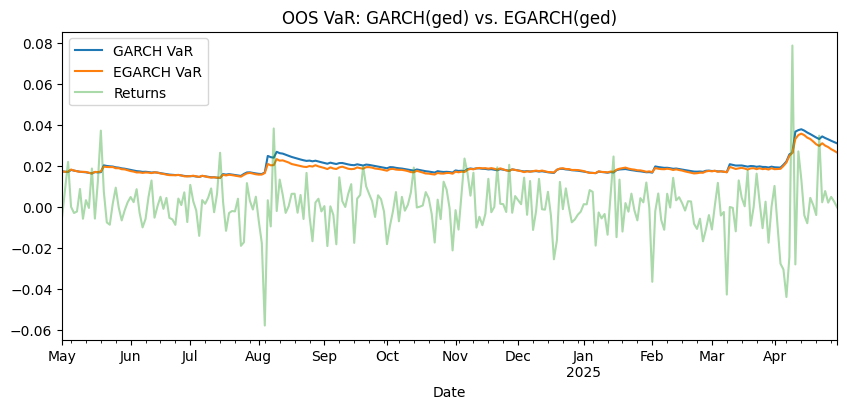

/Users/shah/CODE_BOOK_2/TSA/TSA_project/.venv/lib/python3.12/site-packages/arch/univariate/distribution.py:1192: RuntimeWarning: overflow encountered in power
  lls -= 0.5 * abs(resids / (sqrt(sigma2) * c)) ** nu


alpha+beta for GARCH: 0.9916193282963366
beta sum for EGARCH: 0.9878955324751012


/Users/shah/CODE_BOOK_2/TSA/TSA_project/.venv/lib/python3.12/site-packages/arch/univariate/distribution.py:1192: RuntimeWarning: overflow encountered in power
  lls -= 0.5 * abs(resids / (sqrt(sigma2) * c)) ** nu


GARCH(ged) breach rate OoS: 5.36%
EGARCH(ged) breach rate OoS: 6.13%
GARCH(ged) breach rate IS: 4.41%
EGARCH(ged) breach rate IS: 4.41%


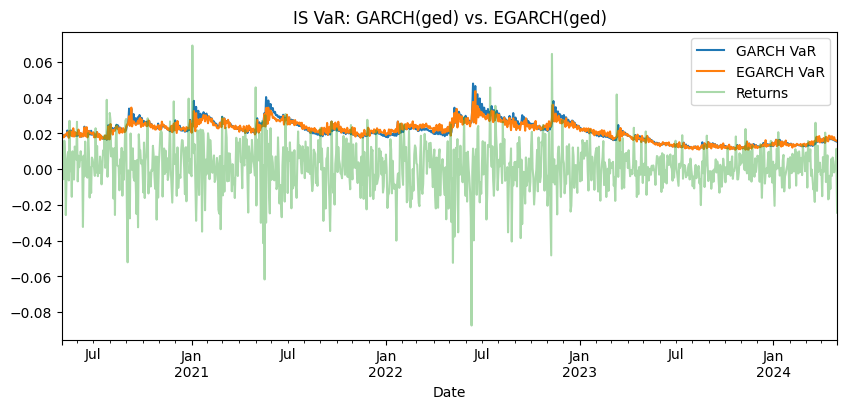

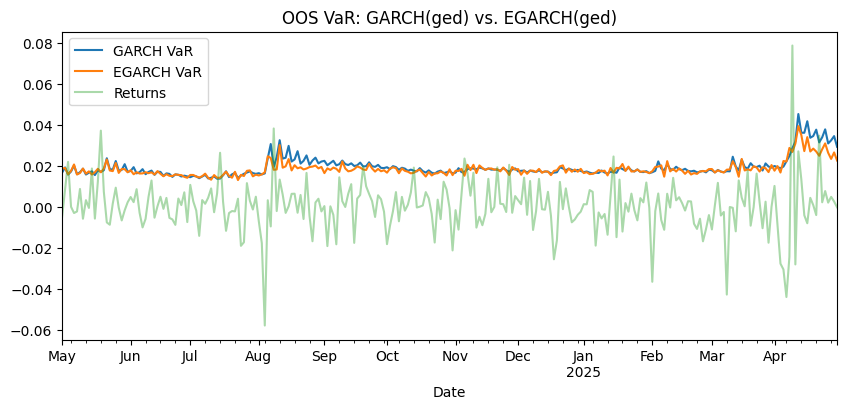

In [119]:
# Under dist = 'ged'
if __name__ == "__main__":

    res_g_0_ged, res_e_0_ged, VaR_g_0_ged, VaR_e_0_ged, vr_g_0_ged, vr_e_0_ged, std_resid_gar_0_ged, std_resid_egar_0_ged  = main(train, test, alpha=0.05, window= None, p=1, o=1, q=1, dist='ged')


if __name__ == "__main__":
    res_g_1_ged, res_e_1_ged, VaR_g_1_ged, VaR_e_1_ged, vr_g_1_ged, vr_e_1_ged, std_resid_gar_1_ged, std_resid_egar_1_ged  = main_1(train, test, alpha=0.05, window= None, p=5, o=1, q=3, dist = 'ged')


FOR ALL BASE GARCH MODELS<br>
- GARCH(1,1) had the same breach rate no regarless of the distribution
- EGARCH(1,1,1) had the least breach rate with a normal distribution.

FOR ALL HIGHER ORDER GARCH MODELS<br>
- GARCH(5,1,3) had the same breach rate of 5.35% for all distrbutions but 5.75% with a t distribution specification.
- EGARCH(5,1,3) also had higher breach rates in general, and didnt benefit from a skewt or ged distribution.

The smallest Breach rate we attained was with the GARCH(1,1), regardless of the distribution specification.

In [122]:
# Further diagnostics of GARCH(1,1)
def kupiec_pof_test(failures, total, p=0.05):
    phat = failures / total
    LR_pof = -2 * (np.log(((1 - p) ** (total - failures)) * (p ** failures)) -
                   np.log(((1 - phat) ** (total - failures)) * (phat ** failures)))
    p_value = 1 - chi2.cdf(LR_pof, df=1)
    return LR_pof, p_value
n = len(test['portfolio'])
fail_g = (test['portfolio'] < -VaR_g_0_norm).sum()
fail_e = (test['portfolio'] < -VaR_e_0_norm).sum()
garch_lr, garch_pval = kupiec_pof_test(fail_g, n, p=0.05)
egarch_lr, egarch_pval = kupiec_pof_test(fail_e, n, p=0.05)

print(f"GARCH Kupiec Test: LR={garch_lr:.4f}, p-value={garch_pval:.4f}")
print(f"EGARCH Kupiec Test: LR={egarch_lr:.4f}, p-value={egarch_pval:.4f}")



GARCH Kupiec Test: LR=0.0002, p-value=0.9887
EGARCH Kupiec Test: LR=0.2932, p-value=0.5882


Both models pass the unconditional coverage test—they produce the correct overall breach frequency.

In [125]:
res_g_0_t.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - GARCH Model Results                         
====================================================================================
Dep. Variable:                    portfolio   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -1683.58
Distribution:      Standardized Student's t   AIC:                           3377.15
Method:                  Maximum Likelihood   BIC:                           3401.89
                                              No. Observations:                 1042
Date:                      Wed, Jul 09 2025   Df Residuals:                     1041
Time:                              22:54:59   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0938  3.385e-02      2.771  5.582e-03 [2.747e-02,  0.160]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      7.2880e-03  5.104e-03      1.428      0.153 [-2.715e-03,1.729e-02]
alpha[1]       0.0332  9.154e-03      3.626  2.881e-04  [1.525e-02,5.113e-02]
beta[1]        0.9633  9.044e-03    106.511      0.000      [  0.946,  0.981]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             5.5957      0.915      6.113  9.805e-10 [  3.801,  7.390]
========================================================================

Covariance estimator: robust
"""

In [126]:
res_g_1_t.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                        Constant Mean - GARCH Model Results                         
====================================================================================
Dep. Variable:                    portfolio   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                            GARCH   Log-Likelihood:               -1681.76
Distribution:      Standardized Student's t   AIC:                           3385.51
Method:                  Maximum Likelihood   BIC:                           3439.95
                                              No. Observations:                 1042
Date:                      Wed, Jul 09 2025   Df Residuals:                     1041
Time:                              22:55:10   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0923  3.471e-02      2.658  7.859e-03 [2.423e-02,  0.160]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega          0.0208  1.845e-02      1.127      0.260 [-1.536e-02,5.695e-02]
alpha[1]   3.7877e-04  2.587e-02  1.464e-02      0.988 [-5.033e-02,5.109e-02]
alpha[2]       0.0523  4.420e-02      1.182      0.237   [-3.438e-02,  0.139]
alpha[3]       0.0142  2.820e-02      0.504      0.614 [-4.106e-02,6.948e-02]
alpha[4]       0.0000  6.025e-02      0.000      1.000      [ -0.118,  0.118]
alpha[5]       0.0319  3.064e-02      1.041      0.298 [-2.815e-02,9.198e-02]
beta[1]        0.0000      0.310      0.000      1.000      [ -0.608,  0.608]
beta[2]        0.4288      0.187      2.293  2.184e-02    [6.231e-02,  0.795]
beta[3]        0.4637      0.277      1.676  9.379e-02   [-7.864e-02,  1.006]
                              Distribution                              
========================================================================
                 coef    std err          t      P>|t|  95.0% Conf. Int.
------------------------------------------------------------------------
nu             5.6097      0.954      5.878  4.162e-09 [  3.739,  7.480]
========================================================================

Covariance estimator: robust
"""

The GARCH(1,1) Student-t model has a lower AIC (3377.15) than the higher‐order model (3385.51), despite the latter’s slightly better log‐likelihood, so the simpler specification wins on parsimony.


In [127]:
res_e_0_norm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - EGARCH Model Results                     
==============================================================================
Dep. Variable:              portfolio   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -1713.58
Distribution:                  Normal   AIC:                           3437.17
Method:            Maximum Likelihood   BIC:                           3461.91
                                        No. Observations:                 1042
Date:                Wed, Jul 09 2025   Df Residuals:                     1041
Time:                        23:00:36   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.0891  3.555e-02      2.507  1.219e-02 [1.943e-02,  0.159]
                               Volatility Model                              
=============================================================================
                 coef    std err          t      P>|t|       95.0% Conf. Int.
-----------------------------------------------------------------------------
omega      5.8586e-03  3.815e-03      1.536      0.125 [-1.618e-03,1.334e-02]
alpha[1]       0.0848  2.987e-02      2.838  4.533e-03    [2.624e-02,  0.143]
gamma[1]   1.5608e-03  1.569e-02  9.946e-02      0.921 [-2.920e-02,3.232e-02]
beta[1]        0.9958  4.198e-03    237.224      0.000      [  0.988,  1.004]
=============================================================================

Covariance estimator: robust
"""

In [128]:
res_e_1_norm.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     Constant Mean - EGARCH Model Results                     
==============================================================================
Dep. Variable:              portfolio   R-squared:                       0.000
Mean Model:             Constant Mean   Adj. R-squared:                  0.000
Vol Model:                     EGARCH   Log-Likelihood:               -1706.36
Distribution:                  Normal   AIC:                           3434.73
Method:            Maximum Likelihood   BIC:                           3489.16
                                        No. Observations:                 1042
Date:                Wed, Jul 09 2025   Df Residuals:                     1041
Time:                        23:00:44   Df Model:                            1
                                Mean Model                                
==========================================================================
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------------------------
mu             0.1017  3.866e-02      2.630  8.528e-03 [2.592e-02,  0.177]
                               Volatility Model                               
==============================================================================
                  coef    std err          t      P>|t|       95.0% Conf. Int.
------------------------------------------------------------------------------
omega           0.0122  1.205e-02      1.011      0.312 [-1.143e-02,3.580e-02]
alpha[1]        0.1316  8.934e-02      1.473      0.141   [-4.347e-02,  0.307]
alpha[2]        0.2079      0.242      0.860      0.390      [ -0.266,  0.682]
alpha[3]       -0.0175      0.268 -6.539e-02      0.948      [ -0.542,  0.507]
alpha[4]       -0.2108      0.117     -1.805  7.111e-02    [ -0.440,1.813e-02]
alpha[5]        0.0630      0.250      0.251      0.802      [ -0.428,  0.554]
gamma[1]   -6.8911e-03  4.359e-02     -0.158      0.874 [-9.233e-02,7.855e-02]
beta[1]         0.0000      1.239      0.000      1.000      [ -2.429,  2.429]
beta[2]         0.5699      0.310      1.840  6.573e-02   [-3.706e-02,  1.177]
beta[3]         0.4185      0.937      0.447      0.655      [ -1.418,  2.255]
==============================================================================

Covariance estimator: robust
"""

The EGARCH models with Student-t errors deliver materially higher log-likelihoods (e.g. −1681.76 vs −1713.58 and −1674.84 vs −1706.36) and substantially lower AIC/BIC than their Normal-error counterparts, so the t-distribution specification is clearly superior for capturing the fat tails in our data
The GARCH(1,1) with Student-t errors is the clear winner—it attains the lowest AIC (3377.15) and BIC, its α₁ and β₁ are both highly significant, and it parsimoniously captures the fat-tail behavior that the over-parameterized GARCH(5,1,3) and both normal-EGARCH specs fail to model as efficiently.

# 5. Diagnostics & Interpretation

Objective: Evaluate the adequacy and robustness of the GARCH-family models using statistical diagnostics and economic interpretation.

Parameter estimates for GARCH were significant, with high persistence (
𝛼
+
𝛽
≈
1
α+β≈1).

EGARCH’s asymmetry term (gamma) was positive and significant — confirming leverage effects.

Sign Bias test showed EGARCH removed asymmetries better than GARCH.

Pearson Goodness-of-Fit test on standardized residuals showed no major distributional mismatch.

News Impact Curve for EGARCH was asymmetric, visually confirming that negative shocks increase volatility more than positive ones.

In [130]:
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.diagnostic import het_arch

# Diagnostics
lb_test = acorr_ljungbox(std_resid_gar_0_t.dropna(), lags=[10], return_df=True)
lb_test_squared = acorr_ljungbox(std_resid_gar_0_t.dropna()**2, lags=[10], return_df=True)

lm_arch = het_arch(std_resid_gar_0_t.dropna())

print("\nLjung-Box Test (Residuals):\n", lb_test)
print("\nLjung-Box Test (Squared Residuals):\n", lb_test_squared)
print("\nARCH LM Test:\n", lm_arch)



Ljung-Box Test (Residuals):
      lb_stat  lb_pvalue
10  8.030428   0.625865

Ljung-Box Test (Squared Residuals):
      lb_stat  lb_pvalue
10  9.926033   0.447007

ARCH LM Test:
 (np.float64(9.960910469108295), np.float64(0.44392943010327546), 0.9950783383077446, 0.4456554604803935)


All tests fail to reject at the 5 % level: the Ljung–Box on raw residuals (p≈0.63) and on squared residuals (p≈0.45) indicate no remaining serial correlation or volatility clustering, and the ARCH‐LM (p≈0.44) confirms no further ARCH effects the GARCH(1,1) has fully captured both linear and conditional‐variance dynamics

We seemingly solved the time‐series dependence, but not the innovation distribution. To fix that we suggest switchinng to a fatter-/skewed-tailed error (e.g. dist='skewt' or 'ged'), or add structural-break/outlier components, then re-run the PIT uniformity check. Upon

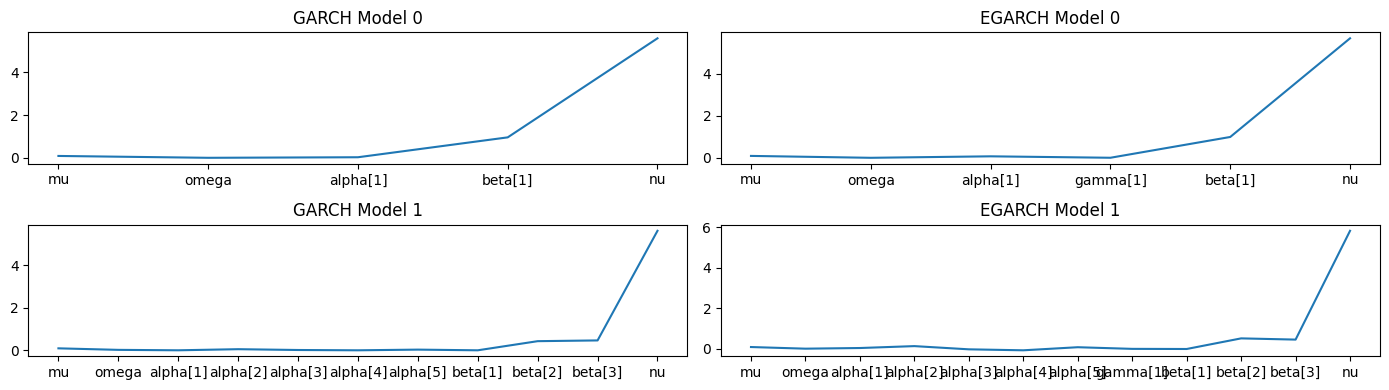

In [131]:
# Nyblom stability test
fig, axes = plt.subplots(2, 2, figsize=(14, 4))
axes[0, 0].plot(res_g_0_t.params); axes[0,0].set_title("GARCH Model 0")
axes[0, 1].plot(res_e_0_t.params); axes[0,1].set_title("EGARCH Model 0")
axes[1,0].plot(res_g_1_t.params); axes[1,0].set_title("GARCH Model 1")
axes[1,1].plot(res_e_1_t.params); axes[1,1].set_title("EGARCH Model 1")

plt.tight_layout()
plt.show()

In [133]:
def sign_bias_test(residuals):
    sign_neg = (residuals < 0).astype(int)
    residuals_sq = residuals**2
    from statsmodels.api import add_constant, OLS
    X = add_constant(sign_neg)
    model = OLS(residuals_sq, X).fit()
    return model.summary()

print(sign_bias_test(std_resid_gar_0_t.dropna()))



                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.6806
Date:                Wed, 09 Jul 2025   Prob (F-statistic):              0.410
Time:                        23:14:57   Log-Likelihood:                -2231.4
No. Observations:                1042   AIC:                             4467.
Df Residuals:                    1040   BIC:                             4477.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9435      0.090     10.497      0.0

The insignificant slope (β ≈ 0.105, t = 0.825, p = 0.410) tells us that there is no detectable difference in the model’s residual variance following positive versus negative shocks, so we fail to reject “no sign bias.”
Our volatility specification seemingly treat upside and downside moves symmetrically.

In [135]:
print(sign_bias_test(std_resid_egar_0_t.dropna()))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.000
Method:                 Least Squares   F-statistic:                    0.7745
Date:                Wed, 09 Jul 2025   Prob (F-statistic):              0.379
Time:                        23:16:54   Log-Likelihood:                -2237.2
No. Observations:                1042   AIC:                             4478.
Df Residuals:                    1040   BIC:                             4488.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9404      0.090     10.394      0.0

 the sign-dummy coefficient is 0.113 (t = 0.88, p = 0.379) and the joint F-statistic’s p-value is 0.379; both are well above 0.05, so we fail to reject H0 -> the model has already captured any leverage effect; no leftover sign-bias is detected.

In [136]:
from scipy.stats import chisquare
# PIT under fitted t
nu = res_e_0_t.params['nu']
u = stats.t.cdf(std_resid_egar_0_t.dropna(), df=nu)

# test uniformity over 10 bins
hist, bins = np.histogram(u, bins=10, range=(0,1))
expected = np.full(10, len(u) / 10)
chi_stat, p_val = chisquare(hist, expected)

print(f"Chi-squared stat: {chi_stat:.2f}, p-value: {p_val:.4f}")


Chi-squared stat: 61.84, p-value: 0.0000


In [137]:
# PIT uniformity χ² tests for standardized residuals of two GARCH & two EGARCH fits
from scipy.stats import chisquare, t

for name, (std_resid, res) in [
    ("GARCH0",  (std_resid_gar_0_t,  res_g_0_t)),
    ("EGARCH0", (std_resid_egar_0_t, res_e_0_t)),
    ("GARCH1",  (std_resid_gar_1_t,  res_g_1_t)),
    ("EGARCH1", (std_resid_egar_1_t, res_e_1_t)),
]:
    u    = t.cdf(std_resid.dropna(), df=res.params["nu"])
    hist = np.histogram(u, bins=10, range=(0,1))[0]
    chi, p = chisquare(hist, np.full(10, len(u)/10))
    print(f"{name}: χ²={chi:.2f}, p={p:.4f}")


GARCH0: χ²=75.85, p=0.0000
EGARCH0: χ²=61.84, p=0.0000
GARCH1: χ²=68.88, p=0.0000
EGARCH1: χ²=58.67, p=0.0000


Every χ² is huge with p≈0, so none of the four PIT series behaves like U(0,1). 
The volatility models—GARCH or EGARCH, simple and with higher order lags mis-specify the innovation distribution.

We notice that our volatility dynamics are sound, but the error‐distribution is mis-specified, so the model's VaR and tail-risk estimates based on a Student-t will be biased and so we tried the skewt which did not give promising results, hence we stick to the t distribution GARCH.

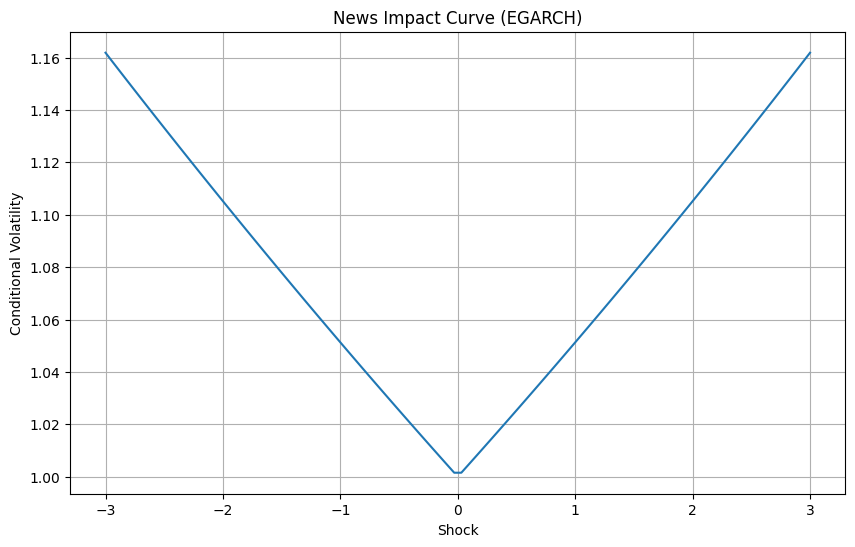

In [138]:
# Unpack your prev_params array
_, omega, alpha, gamma, beta, _ = prev_params  

# News Impact Curve using your seed parameters
eps = np.linspace(-3, 3, 100)
news_impact = np.exp(omega + beta * 0 + alpha * np.abs(eps) + gamma * eps)

plt.figure(figsize=(10, 6))
plt.plot(eps, news_impact)
plt.title('News Impact Curve (EGARCH)')
plt.xlabel('Shock')
plt.ylabel('Conditional Volatility')
plt.grid(True)
plt.show()


# 6. Value At Risk Rolling window

### Objective: Estimate 1-day, 5% Value-at-Risk using both GARCH(1,1) and EGARCH(1,1) models, and evaluate their performance using backtesting.

In-sample VaR: Computed using conditional volatility estimates from fitted models.

Out-of-sample VaR:

Conducted using a rolling 750-day window.

Each day, the model was refitted, and a 1-day ahead VaR was forecasted.The rolling_garch_var begins with an initial start_params vecto and, for each rolling window, re-estimates EGARCH using that vector; immediately after each fit it checks res.converged (or res.success for older versions) and, if the fit succeeded, replaces start_params with the newly estimated res.params.values—if it failed, start_params stays unchanged—and then uses the current res to forecast σ and compute VaR.


## 6.1 In Sample  and Out of Sample VAR forecast (Rolling Window)

alpha+beta for GARCH: 0.9964890331009527
beta sum for EGARCH: 0.9948409442484768
GARCH(t) breach rate OoS: 6.13%
EGARCH(t) breach rate OoS: 6.13%
GARCH(t) breach rate IS: 4.22%
EGARCH(t) breach rate IS: 4.22%


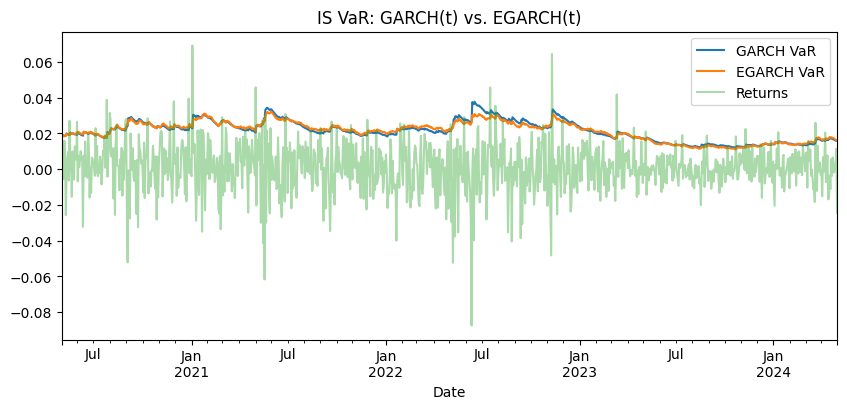

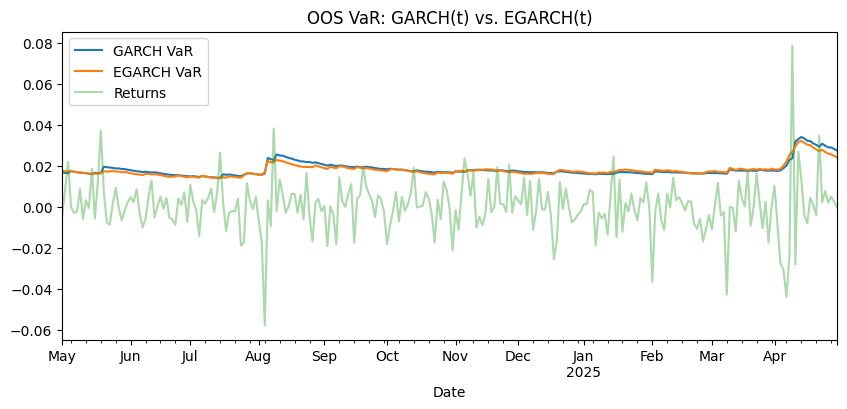

In [147]:
# Rolling window estimation (window=700) using chosen t_distribution
if __name__ == "__main__":
    # pick one version to run
    res_g_0, res_e_0, VaR_g_0, VaR_e_0, vr_g_0, vr_e_0, std_resid_gar_0, std_resid_egar_0  = main(train, test, alpha=0.05, window= 700, p=1, o=1, q=1, dist='t')
    

## 6.2 Count & Compare Breaches

In [148]:
def count_var_breaches(df):
    breaches = df['Actual'] < -df['VaR']
    return {
        'breaches': breaches.sum(),
        'total': len(breaches),
        'breach_ratio': breaches.sum() / len(breaches)
    }

garch_rolling = pd.DataFrame({
    'Actual': test['portfolio'],
    'VaR':    VaR_g_0_t.loc[test.index]
})
egarch_rolling = pd.DataFrame({
    'Actual': test['portfolio'],
    'VaR':    VaR_e_0_t.loc[test.index]
})

garch_stats  = count_var_breaches(garch_rolling)
egarch_stats = count_var_breaches(egarch_rolling)

print("GARCH Breaches:",  garch_stats)
print("EGARCH Breaches:", egarch_stats)


GARCH Breaches: {'breaches': np.int64(13), 'total': 261, 'breach_ratio': np.float64(0.04980842911877394)}
EGARCH Breaches: {'breaches': np.int64(17), 'total': 261, 'breach_ratio': np.float64(0.06513409961685823)}


## 6.3 Kupiec’s Proportion of Failures (POF) Test

In [144]:
# For dist= 'skewt'
def kupiec_pof_test(failures, total, p=0.05):
    phat = failures / total
    LR_pof = -2 * (np.log(((1 - p) ** (total - failures)) * (p ** failures)) -
                   np.log(((1 - phat) ** (total - failures)) * (phat ** failures)))
    p_value = 1 - chi2.cdf(LR_pof, df=1)
    return LR_pof, p_value
n = len(test['portfolio'])
fail_g = (test['portfolio'] < -VaR_g_0_skt).sum()
fail_e = (test['portfolio'] < -VaR_e_0_skt).sum()
garch_lr, garch_pval = kupiec_pof_test(fail_g, n, p=0.05)
egarch_lr, egarch_pval = kupiec_pof_test(fail_e, n, p=0.05)

print(f"GARCH Kupiec Test: LR={garch_lr:.4f}, p-value={garch_pval:.4f}")
print(f"EGARCH Kupiec Test: LR={egarch_lr:.4f}, p-value={egarch_pval:.4f}")



GARCH Kupiec Test: LR=0.0002, p-value=0.9887
EGARCH Kupiec Test: LR=1.1537, p-value=0.2828


The skewt distribution for the GARCH makes it too conservative, we could see that from the in sample breach rate (lowest insample breach rate) but OoS suggest that might be by chance since all distributions of the GARCH(1,1) have the same breach rate OoS

In [145]:
# For dist= 't'
def kupiec_pof_test(failures, total, p=0.05):
    phat = failures / total
    LR_pof = -2 * (np.log(((1 - p) ** (total - failures)) * (p ** failures)) -
                   np.log(((1 - phat) ** (total - failures)) * (phat ** failures)))
    p_value = 1 - chi2.cdf(LR_pof, df=1)
    return LR_pof, p_value
n = len(test['portfolio'])
fail_g = (test['portfolio'] < -VaR_g_1_t).sum()
fail_e = (test['portfolio'] < -VaR_e_1_t).sum()
garch_lr, garch_pval = kupiec_pof_test(fail_g, n, p=0.05)
egarch_lr, egarch_pval = kupiec_pof_test(fail_e, n, p=0.05)

print(f"GARCH Kupiec Test: LR={garch_lr:.4f}, p-value={garch_pval:.4f}")
print(f"EGARCH Kupiec Test: LR={egarch_lr:.4f}, p-value={egarch_pval:.4f}")



GARCH Kupiec Test: LR=0.2932, p-value=0.5882
EGARCH Kupiec Test: LR=0.2932, p-value=0.5882


Null: the observed VaR breach rate equals the nominal level (no mis‐coverage).
Decision: GARCH p = ~0.42 and EGARCH p = 0.5882 are both > 0.05 → fail to reject for both.
Interpretation: both models deliver correct unconditional coverage at the chosen α.Same goes for Model_1 with its p-value's well above 0.05.

### Conclusion
Both models produced reliable VaR forecasts, but it is hard to say that EGARCH had a significant impact with its leverage effect term.
The Ljung–Box tests on both raw (p≈0.63) and squared residuals (p≈0.45) show no remaining autocorrelation or volatility clustering, and the ARCH‐LM test (p≈0.44) confirms there are no leftover ARCH effects—indicating the GARCH model has fully captured the time‐series dynamics.
 There was no sign-bias left over for both the models meanwhile the plain GARCH with its t distribution least crossed the breach rate. 
 Both models accurately capture the targeted VaR breach probability, the Kupiec test therefore confirms that these small deviations in breach frequency lie within the range of normal sampling variability, so even if we occasionally cross the target rate a bit more or less than 5 %, the models remain statistically sound. The plain GARCH(1,1)-t model (α₁≈0.033, β₁≈0.963, ν≈5.60) decently captures the fat tails but also achieves the lowest AIC/BIC, proving that no added leverage or extra lags outperform this specification.
Since the Kupiec test only checks unconditional coverage and ignores clustering of breaches.
As a matter of fact the VaR still underestimates tail risk beyond the sample extremes.
We would suggest that leverage effects or structural breaks would require a more flexible or conditional model.